## ライブラリのインポート

In [1]:
import random, copy, os
from graphviz import Graph
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import cv2

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

import zss
from zss import simple_distance
import pyconll
import ot

import multiprocessing as mp
import wasserTest_defs
from tqdm.notebook import tqdm_notebook as tqdm
from scipy.stats import gmean

from pathlib import Path
from collections import Counter

%matplotlib inline

In [2]:
cnt = 0
for name, path_str in wasserTest_defs.CORPORA_PATH.items():
    path = Path(path_str)
    if not path.is_file():
        cnt += 1
        print(f"no file {path_str}")
cnt

0

In [4]:
def conll_to_zss_unlabel(tree: pyconll.tree)->zss.Node:
    node = zss.Node("_")
    for child in tree:
        node.addkid(conll_to_zss_unlabel(child))
    return node

In [5]:
CORPORA_DIR = "/home/yamazoe/zoe/data/original/treebank/"
POSTFIX = ".conllu"

In [6]:
PATH_ENGLISH = CORPORA_DIR+"English-EWT"+POSTFIX
PATH_JAPANESE = CORPORA_DIR+"Japanese-BCCWJ"+POSTFIX
PATH_CHINESE = CORPORA_DIR+"Chinese-GSD"+POSTFIX
PATH_KOREAN = CORPORA_DIR+"Korean-Kaist"+POSTFIX
PATH_FRENCH = CORPORA_DIR+"French-GSD"+POSTFIX

In [7]:
N = 20
seed = 0

In [8]:

def calcDistOne(treepair):
    return float(simple_distance(treepair[0], treepair[1]))


def calcDist(setTreeN):
    numData = len(setTreeN)
    #print(".....calculating distances among "+str(numData)+" trees")
    
    distArray = np.zeros((numData, numData), dtype=float)
    
    cpu_num = mp.cpu_count()
    pairs = []
    for i in range(numData):
        for j in range(i):
            pairs.append((setTreeN[i],setTreeN[j]))

    p = mp.Pool(cpu_num)            
    #result = p.map(calcDistOne, pairs)
    result = p.map(calcDistOne, tqdm(pairs))
    #print("len=",len(result))
    
    count = 0
    for i in range(numData):
        distArray[i][i] = 0
        for j in range(i):
            distArray[i][j] = result[count]
            distArray[j][i] = result[count]
            count += 1
    p.close()

    return distArray

In [9]:
def cutOutInds(distArray,Xinds,Yinds):

    len_x = len(Xinds)
    len_y = len(Yinds)     
    
    matC = np.zeros((len_x, len_y), dtype=float)
    
    for i in range(len_x):
        for j in range(len_y):
            matC[i][j] = float(distArray[Xinds[i]][Yinds[j]])
            
    return matC

In [10]:
def wasserstein_test(src_all, tgt_all, random_state=0, sample_size=200):
    
    random.seed(random_state)
    if len(src_all)>sample_size:
        src = random.sample(src_all, k=sample_size)
    else:
        src = copy.deepcopy(src_all)
    if len(tgt_all)>sample_size:
        tgt = random.sample(tgt_all, k=sample_size)
    else:
        tgt = copy.deepcopy(tgt_all)


    len_src = len(src)
    len_tgt = len(tgt)

    distArray = calcDist(src + tgt)
    costMatrix = cutOutInds(distArray, list(range(len_src)), list(range(len_src, len_src+len_tgt)))
    # Compute the Wasserstein distance

    weight_i = np.ones(len_src)/float(len_src)  #weight is equal        
    weight_j = np.ones(len_tgt)/float(len_tgt)  #weight is equal

    ot_emd = ot.emd(weight_i, weight_j, costMatrix)
    cost = np.sum(ot_emd * costMatrix)
    
    return distArray, cost

In [11]:
def calcDistOne(treepair):
    return float(simple_distance(treepair[0], treepair[1]))

def calcDist_multiprocess(setTreeN):
    numData = len(setTreeN)
    #print(".....calculating distances among "+str(numData)+" trees")
    
    distArray = np.zeros((numData, numData), dtype=float)
    
    cpu_num = mp.cpu_count()
    pairs = []
    for i in range(numData):
        for j in range(i):
            pairs.append((setTreeN[i],setTreeN[j]))

    p = mp.Pool(cpu_num)            
    #result = p.map(calcDistOne, tqdm(pairs))
    result = p.map(calcDistOne, tqdm(pairs))
    #print("len=",len(result))
    
    count = 0
    for i in range(numData):
        distArray[i][i] = 0
        for j in range(i):
            distArray[i][j] = result[count]
            distArray[j][i] = result[count]
            count += 1
    p.close()

    return distArray

In [12]:
DISTMX_DIR = "/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/"

## 実行

In [ ]:
conll_en = pyconll.load_from_file(PATH_ENGLISH)
tree_en_N_all = []
for conll in conll_en:
    if len(conll) == N:
        tree_en_N_all.append(conll.to_tree())
tree_en_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_en_N_all]

conll_ja = pyconll.load_from_file(PATH_JAPANESE)
tree_ja_N_all = []
for conll in conll_ja:
    if len(conll) == N:
        tree_ja_N_all.append(conll.to_tree())
tree_ja_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_ja_N_all]

conll_ko = pyconll.load_from_file(PATH_KOREAN)
tree_ko_N_all = []
for conll in conll_ko:
    if len(conll) == N:
        tree_ko_N_all.append(conll.to_tree())
tree_ko_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_ko_N_all]

conll_fr = pyconll.load_from_file(PATH_FRENCH)
tree_fr_N_all = []
for conll in conll_fr:
    if len(conll) == N:
        tree_fr_N_all.append(conll.to_tree())
tree_fr_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_fr_N_all]

In [ ]:
distArray, cost = wasserstein_test(tree_en_zss_N_all, tree_ja_zss_N_all)
np.save(DISTMX_DIR+"English-EWT_Japanese-BCCWJ.npy", distArray)

In [ ]:
cost

In [ ]:
X_reduced = TSNE(n_components=2, random_state=42).fit_transform(distArray)
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT')
plt.scatter(X_reduced[200:, 0], X_reduced[200:, 1], label='Korean-Kaist')

In [ ]:
tree_en_zss_N = random.sample(tree_en_zss_N_all, k=200)
tree_ja_zss_N = random.sample(tree_ja_zss_N_all, k=200)
tree_fr_zss_N = random.sample(tree_fr_zss_N_all, k=200)
tree_ko_zss_N = random.sample(tree_ko_zss_N_all, k=200)

distArray = calcDist_multiprocess(tree_en_zss_N + tree_ja_zss_N + tree_fr_zss_N + tree_ko_zss_N)
np.save(DISTMX_DIR+"multiple.npy", distArray)

In [ ]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distArray)


fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English', )
ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='Japanese')
ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='French')
ax.scatter(X_reduced[600:800, 0], X_reduced[600:800, 1], label='Korean')



plt.savefig("ud_tsne.png")

In [ ]:
import multiprocessing as mp

In [ ]:
def calcDistOne(treepair):
    return float(simple_distance(treepair[0], treepair[1]))

def calcDist_multiprocess(setTreeN):
    numData = len(setTreeN)
    #print(".....calculating distances among "+str(numData)+" trees")
    
    distArray = np.zeros((numData, numData), dtype=float)
    
    cpu_num = mp.cpu_count()
    pairs = []
    for i in range(numData):
        for j in range(i):
            pairs.append((setTreeN[i],setTreeN[j]))

    p = mp.Pool(cpu_num)            
    #result = p.map(calcDistOne, tqdm(pairs))
    result = p.map(calcDistOne, tqdm(pairs))
    #print("len=",len(result))
    
    count = 0
    for i in range(numData):
        distArray[i][i] = 0
        for j in range(i):
            distArray[i][j] = result[count]
            distArray[j][i] = result[count]
            count += 1
    p.close()

    return distArray

In [ ]:
distArray = calcDist_multiprocess(tree_en_zss_N_all[:200]+tree_ja_zss_N_all[:200])

In [ ]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distArray)
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English')
ax.scatter(X_reduced[200:, 0], X_reduced[200:, 1], label='Japanese')
plt.legend()

In [ ]:
tree_en_zss_N = random.sample(tree_en_zss_N_all, k=200)
tree_ja_zss_N = random.sample(tree_ja_zss_N_all, k=200)
tree_fr_zss_N = random.sample(tree_fr_zss_N_all, k=200)
tree_ko_zss_N = random.sample(tree_ko_zss_N_all, k=200)

distArray = calcDist_multiprocess(tree_en_zss_N + tree_ja_zss_N + tree_fr_zss_N + tree_ko_zss_N)
np.save(DISTMX_DIR+"multiple.npy", distArray)

In [ ]:
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(distArray)


In [ ]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', )
ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='Japanese-BCCWJ')
ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='French-GSD')
ax.scatter(X_reduced[600:800, 0], X_reduced[600:800, 1], label='Korean-Kaist')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4)

plt.savefig("multiple_tsne.png")

In [ ]:
conll_en = pyconll.load_from_file(PATH_ENGLISH)
tree_en_N_all = []
for conll in conll_en:
    if len(conll) == N:
        tree_en_N_all.append(conll.to_tree())
tree_en_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_en_N_all]

conll_ja = pyconll.load_from_file(PATH_JAPANESE)
tree_ja_N_all = []
for conll in conll_ja:
    if len(conll) == N:
        tree_ja_N_all.append(conll.to_tree())
tree_ja_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_ja_N_all]

conll_ko = pyconll.load_from_file(PATH_KOREAN)
tree_ko_N_all = []
for conll in conll_ko:
    if len(conll) == N:
        tree_ko_N_all.append(conll.to_tree())
tree_ko_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_ko_N_all]

conll_fr = pyconll.load_from_file(PATH_FRENCH)
tree_fr_N_all = []
for conll in conll_fr:
    if len(conll) == N:
        tree_fr_N_all.append(conll.to_tree())
tree_fr_zss_N_all = [conll_to_zss_unlabel(tree) for tree in tree_fr_N_all]

In [ ]:
import wasserTest_defs

In [ ]:
ewt = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-EWT"])
rand = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-RandCF"])
gpt = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-ChatGPT"])

random.seed(0)
tree_ewt_N = []
for conll in ewt:
    if len(conll) == N:
        tree_ewt_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_ewt_N = random.sample(tree_ewt_N, k=200)

random.seed(10)
tree_rand_N = []
for conll in rand:
    if len(conll) == N:
        tree_rand_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_rand_N = random.sample(tree_rand_N, k=200)

random.seed(20)
tree_gpt_N = []
for conll in gpt:
    if len(conll) == N:
        tree_gpt_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_gpt_N = random.sample(tree_gpt_N, k=200)


In [ ]:
distArray = calcDist_multiprocess(tree_ewt_N + tree_gpt_N + tree_rand_N)
np.save(DISTMX_DIR+"rands_gpt.npy", distArray)

In [ ]:
from matplotlib.font_manager import FontProperties

In [186]:
distArray = np.load("/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/rands_gpt.npy")
X_reduced = TSNE(n_components=2, random_state=42, init="random", metric="precomputed").fit_transform(distArray)

In [187]:
ewt_array= distArray[:200,:200]
gpt_array = distArray[200:400,200:400]
rand_array = distArray[400:600,400:600]

sums_ewt = []
sums_gpt = []
sums_rand = []

for i in range(200):
    sums_ewt.append(np.sum(ewt_array[i]))
    sums_gpt.append(np.sum(gpt_array[i]))
    sums_rand.append(np.sum(rand_array[i]))

gmedians_id = [
    np.argmin(sums_ewt),
    np.argmin(sums_gpt)+200,
    np.argmin(sums_rand)+400,
]

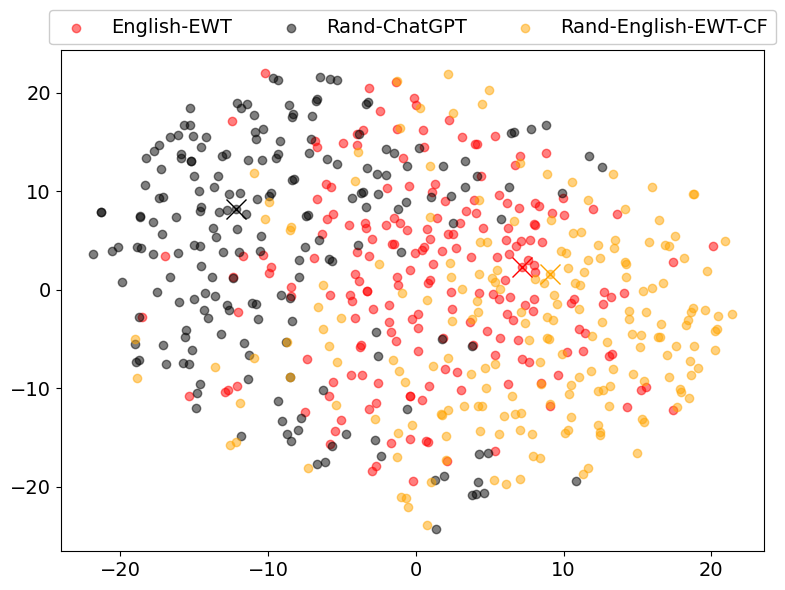

In [194]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))

ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', color='red', alpha=0.5)
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='Rand-ChatGPT', color='black', alpha=0.5)
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='black', markersize=15)

ax.scatter(X_reduced[400:, 0], X_reduced[400:, 1], label='Rand-English-EWT-CF', color='orange', alpha=0.5)
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='orange', markersize=15)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=14)

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("rands_tsne.png", bbox_inches='tight', dpi=300)

In [158]:
distArray = np.load("/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/distmx_multiple.npy")

In [159]:
X_reduced = TSNE(n_components=2, random_state=1, 
                 metric="precomputed", init="random").fit_transform(distArray)

In [160]:
en_array = distArray[:200,:200]
fr_array = distArray[200:400,200:400]
ja_array = distArray[400:600,400:600]
ko_array = distArray[600:,600:]

In [161]:
sums_en = []
sums_fr = []
sums_ja = []
sums_ko = []

for i in range(200):
    sums_en.append(np.sum(en_array[i]))
    sums_fr.append(np.sum(fr_array[i]))
    sums_ja.append(np.sum(ja_array[i]))
    sums_ko.append(np.sum(ko_array[i]))

gmedians_id = [
    np.argmin(sums_en),
    np.argmin(sums_fr)+200,
    np.argmin(sums_ja)+400,
    np.argmin(sums_ko)+600
]

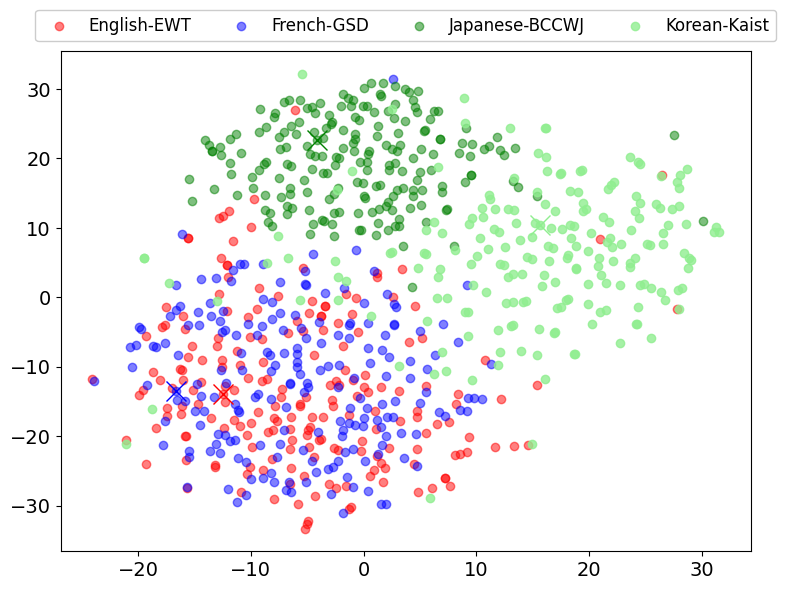

In [164]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='French-GSD', alpha=0.5, color='blue')
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='Japanese-BCCWJ', alpha=0.5, color='green')
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='green', markersize=15)

ax.scatter(X_reduced[600:800, 0], X_reduced[600:800, 1], label='Korean-Kaist', alpha=0.8, color='lightgreen')
ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color='lightgreen', markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', 
                   bbox_to_anchor=(0.5, 1.1), 
                   ncol=4, 
                   #frameon=False,
                   fontsize=12)

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("multiple_tsne.png", bbox_inches='tight', dpi=300)

In [ ]:
ewt = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-EWT"])
atis = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-Atis"])
esl = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-ESL"])
rand = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-RandCF"])

N=20
tree_ewt_N = []
for conll in ewt:
    if len(conll) == N:
        tree_ewt_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_ewt_N = random.sample(tree_ewt_N, k=200)

tree_atis_N = []
for conll in atis:
    if len(conll) == N:
        tree_atis_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
#tree_atis_N = random.sample(tree_atis_N, k=200)

tree_esl_N = []
for conll in esl:
    if len(conll) == N:
        tree_esl_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_esl_N = random.sample(tree_esl_N, k=200)


tree_rand_N = []
for conll in rand:
    if len(conll) == N:
        tree_rand_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_rand_N = random.sample(tree_rand_N, k=200)

distArray = calcDist(tree_ewt_N + tree_atis_N + tree_esl_N + tree_rand_N)


In [93]:
len(distArray)

670

In [130]:
distArray = np.load("/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/distmx_english.npy")
X_reduced = TSNE(n_components=2, random_state=42, metric="precomputed", init="random").fit_transform(distArray[0:470, 0:470])

ewt_array= distArray[:200,:200]
atis_array = distArray[200:270,200:270]
esl_array = distArray[270:470,270:470]
#rand_array = distArray[470:,470:]

sums_ewt = [np.sum(ewt_array[i]) for i in range(200)]
sums_atis = [np.sum(atis_array[i]) for i in range(70)]
sums_esl = [np.sum(esl_array[i]) for i in range(200)]
#sums_rand = [np.sum(rand_array[i]) for i in range(200)]

gmedians_id = [
    np.argmin(sums_ewt),
    np.argmin(sums_atis)+200,
    np.argmin(sums_esl)+270,
    #np.argmin(sums_rand)+470
]



In [ ]:
fr_array

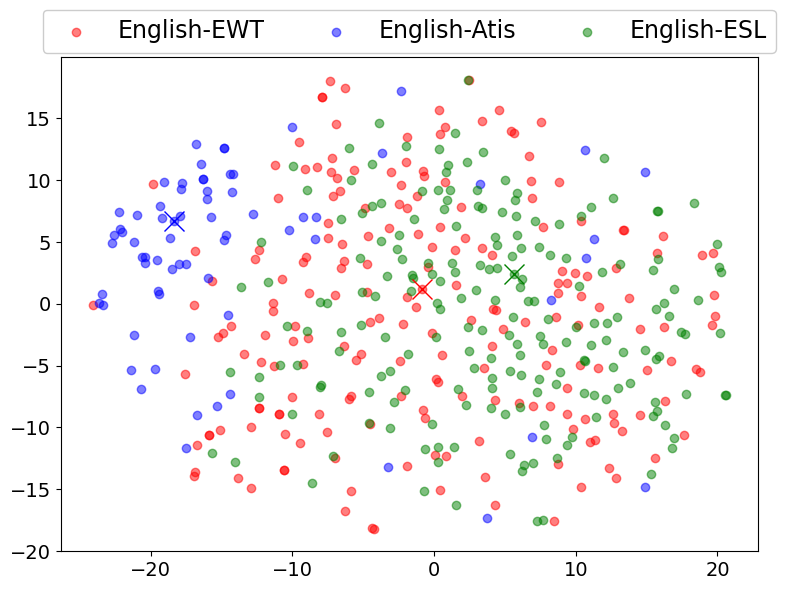

In [ ]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:270, 0], X_reduced[200:270, 1], label='English-Atis', alpha=0.5, color='blue')
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[270:470, 0], X_reduced[270:470, 1], label='English-ESL', alpha=0.5, color='green')
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='green', markersize=15)

#ax.scatter(X_reduced[470:670, 0], X_reduced[470:670, 1], label='Rand-English-EWT-CF', alpha=0.8, color='orange')
#ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color='orange', markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3,  fontsize=17)

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("english_tsne.png", bbox_inches='tight', dpi=300)

In [ ]:
ewt = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-EWT"])
atis = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-Atis"])
esl = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-ESL"])
rand = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-RandCF"])

In [27]:
ewt = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-EWT"])
udpipe = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-EWT-udpipe"])
spacy = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-EWT-spacy"])
gpt = pyconll.load_from_file(wasserTest_defs.CORPORA_PATH["English-ChatGPT"])

In [28]:
N = 20

tree_ewt_N = []
for conll in ewt:
    if len(conll) == N:
        tree_ewt_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_ewt_N = random.sample(tree_ewt_N, k=200)

tree_udpipe_N = []
for conll in udpipe:
    if len(conll) == N:
        tree_udpipe_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_udpipe_N = random.sample(tree_udpipe_N, k=200)

tree_spacy_N = []
for conll in spacy:
    if len(conll) == N:
        tree_spacy_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_spacy_N = random.sample(tree_spacy_N, k=200)

tree_gpt_N = []
for conll in gpt:
    if len(conll) == N:
        tree_gpt_N.append(
            conll_to_zss_unlabel(conll.to_tree())
        )
tree_gpt_N = random.sample(tree_gpt_N, k=200)

In [29]:
distArray = calcDist_multiprocess(tree_ewt_N + tree_udpipe_N + tree_spacy_N + tree_gpt_N)
np.save(DISTMX_DIR+"parsers.npy", distArray)

  0%|          | 0/319600 [00:00<?, ?it/s]

In [73]:
distArray = np.load(DISTMX_DIR+"parsers.npy")

In [74]:
X_reduced = TSNE(n_components=2, random_state=100).fit_transform(distArray)

ewt_array= distArray[:200,:200]
udpipe_array = distArray[200:400,200:400]
spacy_array = distArray[400:600,400:600]
gpt_array = distArray[600:,600:]

sums_ewt = [np.sum(ewt_array[i]) for i in range(200)]
sums_udpipe = [np.sum(udpipe_array[i]) for i in range(200)]
sums_spacy = [np.sum(spacy_array[i]) for i in range(200)]
sums_gpt = [np.sum(gpt_array[i]) for i in range(200)]

gmedians_id = [
    np.argmin(sums_ewt),
    np.argmin(sums_udpipe)+200,
    np.argmin(sums_spacy)+400,
    np.argmin(sums_gpt)+600
]

In [27]:
sums_spacy[153], np.sum(distArray[400+153, 400:600])

(1930.0, 1930.0)

In [24]:
sums_spacy[7], np.argmin(sums_spacy)

(1946.0, 153)

In [23]:
gmedians_id

[126, 233, 553, 708]

In [43]:
sums_ewt[69], sums_ewt[126]

(2632.0, 1548.0)

In [54]:
gmedians_id

[126, 233, 553, 708]

In [46]:
ewt_min = np.inf
ewt_min_id = -1
for i in range(200):
    ewt_sum = np.sum(ewt_array[i])
    if ewt_sum < ewt_min:
        ewt_min = ewt_sum
        ewt_min_id = i
print(ewt_min_id)

126


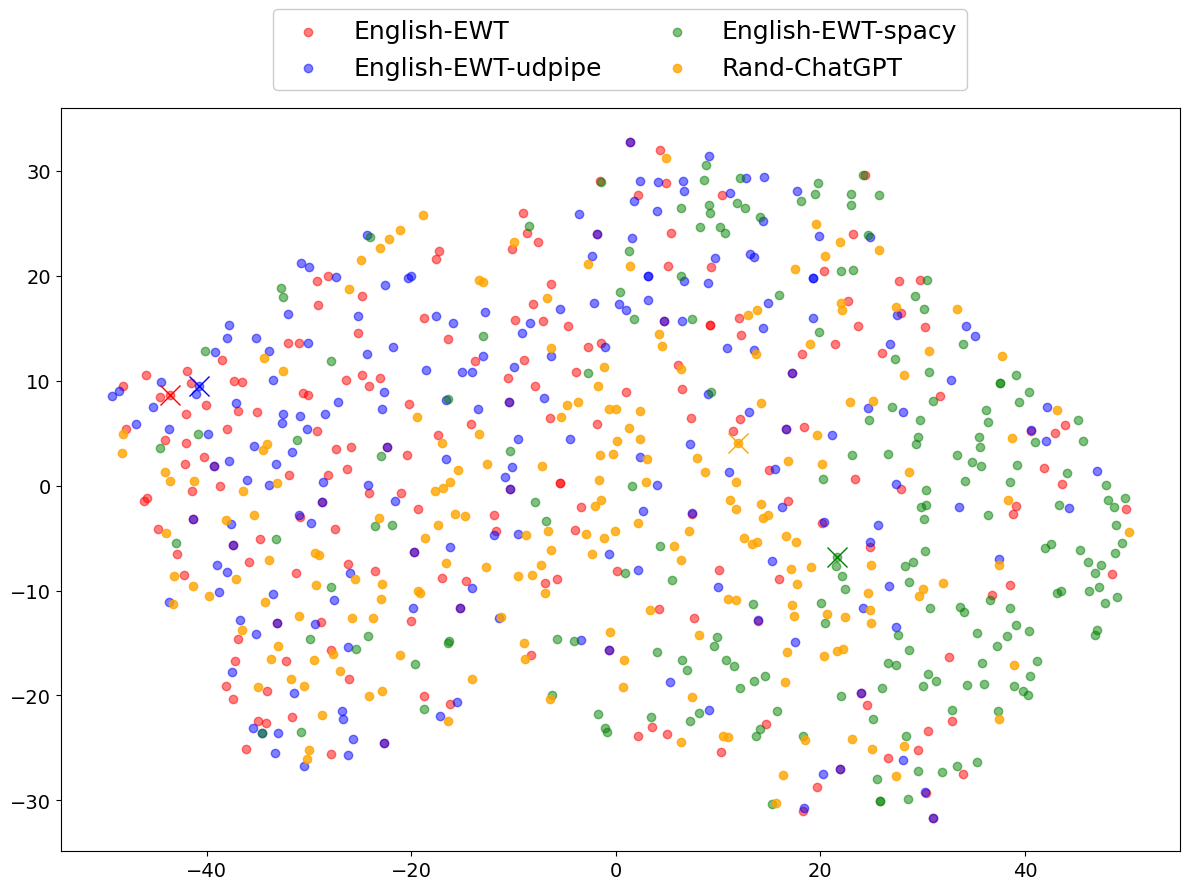

In [80]:
fig, ax = plt.subplots(tight_layout=True, figsize=(12,9))

ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='English-EWT-udpipe', alpha=0.5, color='blue')
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='English-EWT-spacy', alpha=0.5, color='green')
ax.plot(X_reduced[500, 0], X_reduced[500, 1], 'x', color='green', markersize=15)

ax.scatter(X_reduced[600:800, 0], X_reduced[600:800, 1], label='Rand-ChatGPT', alpha=0.8, color='orange')
ax.plot(X_reduced[701, 0], X_reduced[701, 1], 'x', color='orange', markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=18)

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("parsers_gpt_tsne.png", bbox_inches='tight', dpi=300)

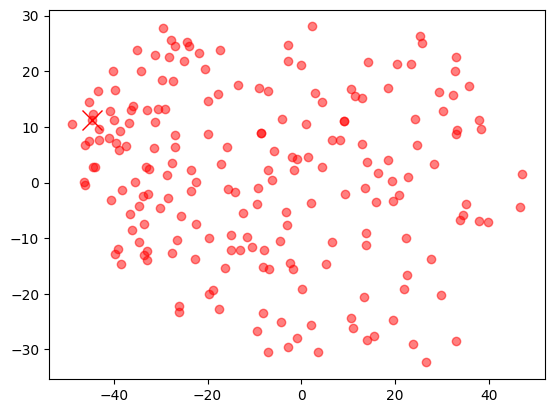

In [35]:
fig, ax = plt.subplots()
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)


In [196]:
distArray = np.load(wasserTest_defs.DISTMX_DIR+"distmx_allen.npy")

In [29]:
distArray.shape

(2000, 2000)

In [197]:
X_reduced = TSNE(n_components=2, random_state=100).fit_transform(distArray[:1600, :1600])


ewt_array = distArray[:200,:200]
cf_array = distArray[200:400,200:400]
uniform_array = distArray[400:600,400:600]
markov2_array = distArray[600:800,600:800]
markov3_array = distArray[800:1000,800:1000]
markov5_array = distArray[1000:1200,1000:1200]
markov10_array = distArray[1200:1400,1200:1200]
gpt_array = distArray[1400:1600,1400:1600]
spacy_array = distArray[1600:1800,1600:1800]
udpipe_array = distArray[1800:2000,1800:2000]


sums_ewt = [np.sum(ewt_array[i]) for i in range(200)]
sums_cf = [np.sum(cf_array[i]) for i in range(200)]
sums_uniform = [np.sum(uniform_array[i]) for i in range(200)]
sums_markov2 = [np.sum(markov2_array[i]) for i in range(200)]
sums_markov3 = [np.sum(markov3_array[i]) for i in range(200)]
sums_markov5 = [np.sum(markov5_array[i]) for i in range(200)]
sums_markov10 = [np.sum(markov10_array[i]) for i in range(200)]
sums_gpt = [np.sum(gpt_array[i]) for i in range(200)]
#sums_spacy = [np.sum(spacy_array[i]) for i in range(200)]
#sums_udpipe = [np.sum(udpipe_array[i]) for i in range(200)]

gmedians_id = [
    np.argmin(sums_ewt),
    np.argmin(sums_cf)+200,
    np.argmin(sums_uniform)+400,
    np.argmin(sums_markov2)+600,
    np.argmin(sums_markov3)+800,
    np.argmin(sums_markov5)+1000,
    np.argmin(sums_markov10)+1200,
    np.argmin(sums_gpt)+1400,
    #np.argmin(sums_spacy)+1600,
    #np.argmin(sums_udpipe)+1800
]
gmedians_id

[35, 200, 576, 635, 928, 1144, 1200, 1514]

In [30]:
markov2_array

array([[ 0., 10.,  8., ...,  8.,  8.,  8.],
       [10.,  0., 10., ..., 16.,  8., 10.],
       [ 8., 10.,  0., ..., 12., 12., 10.],
       ...,
       [ 8., 16., 12., ...,  0., 14.,  8.],
       [ 8.,  8., 12., ..., 14.,  0., 12.],
       [ 8., 10., 10., ...,  8., 12.,  0.]])

In [15]:
np.sum(distArray[35, 0:200])

1469.0

In [16]:
X_reduced[35]

array([-37.934994, -15.789425], dtype=float32)

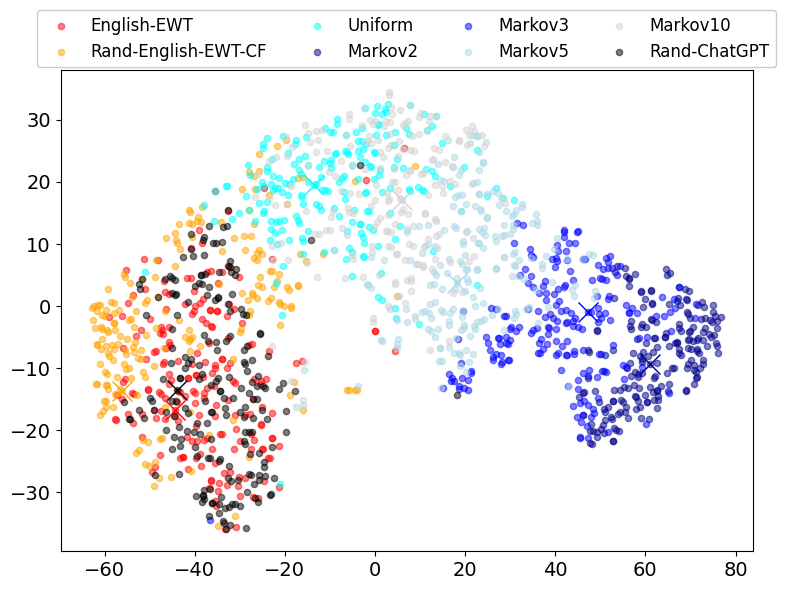

In [198]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))

ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red', s=20)
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='Rand-English-EWT-CF', alpha=0.5, color='orange', s=20)
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='orange', markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='Uniform', alpha=0.5, color='cyan', s=20)
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='cyan', markersize=15)

ax.scatter(X_reduced[600:800, 0], X_reduced[600:800, 1], label='Markov2', alpha=0.5, color='darkblue', s=20)
ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color='darkblue', markersize=15)

ax.scatter(X_reduced[800:1000, 0], X_reduced[800:1000, 1], label='Markov3', alpha=0.5, color='blue', s=20)
ax.plot(X_reduced[gmedians_id[4], 0], X_reduced[gmedians_id[4], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[1000:1200, 0], X_reduced[1000:1200, 1], label='Markov5', alpha=0.5, color='lightblue', s=20)
ax.plot(X_reduced[gmedians_id[5], 0], X_reduced[gmedians_id[5], 1], 'x', color='lightblue', markersize=15)

ax.scatter(X_reduced[1200:1400, 0], X_reduced[1200:1400, 1], label='Markov10', alpha=0.5, color='lightgray', s=20)
ax.plot(X_reduced[gmedians_id[6], 0], X_reduced[gmedians_id[6], 1], 'x', color='lightgray', markersize=15)

ax.scatter(X_reduced[1400:1600, 0], X_reduced[1400:1600, 1], label='Rand-ChatGPT', alpha=0.5, color='black', s=20)
ax.plot(X_reduced[gmedians_id[7], 0], X_reduced[gmedians_id[7], 1], 'x', color='black', markersize=15)

#ax.scatter(X_reduced[1600:1800, 0], X_reduced[1600:1800, 1], label='English-EWT-spacy', alpha=0.5, color='blue')
#ax.plot(X_reduced[gmedians_id[8], 0], X_reduced[gmedians_id[8], 1], 'x', color='blue', markersize=15)


#ax.scatter(X_reduced[1800:, 0], X_reduced[1800:, 1], label='English-EWT-udpipe', alpha=0.5, color='green')
#ax.plot(X_reduced[gmedians_id[9], 0], X_reduced[gmedians_id[9], 1], 'x', color='green', markersize=15)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)
legend = ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.125), 
    ncol=4, 
    fontsize=12,
    frameon=True,
    borderaxespad=0,
)

legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("rands_all_tsne.png", bbox_inches='tight', dpi=300)

### 長さ制限を外すと... 

In [26]:
distArray = np.load(wasserTest_defs.DISTMX_DIR+"english_unlimited.npy")

In [ ]:
X_reduced = TSNE(
    n_components=2, 
    random_state=100, 
    metric="precomputed", 
    init="random").fit_transform(distArray)

In [28]:
ewt_array= distArray[:200,:200]
atis_array = distArray[200:400,200:400]
esl_array = distArray[400:600,400:600]
rand_array = distArray[600:,600:]

sums_ewt = [np.sum(ewt_array[i]) for i in range(200)]
sums_atis = [np.sum(atis_array[i]) for i in range(200)]
sums_esl = [np.sum(esl_array[i]) for i in range(200)]
sums_rand = [np.sum(rand_array[i]) for i in range(200)]

gmedians_id = [
    np.argmin(sums_ewt),
    np.argmin(sums_atis)+200,
    np.argmin(sums_esl)+400,
    np.argmin(sums_rand)+600
]


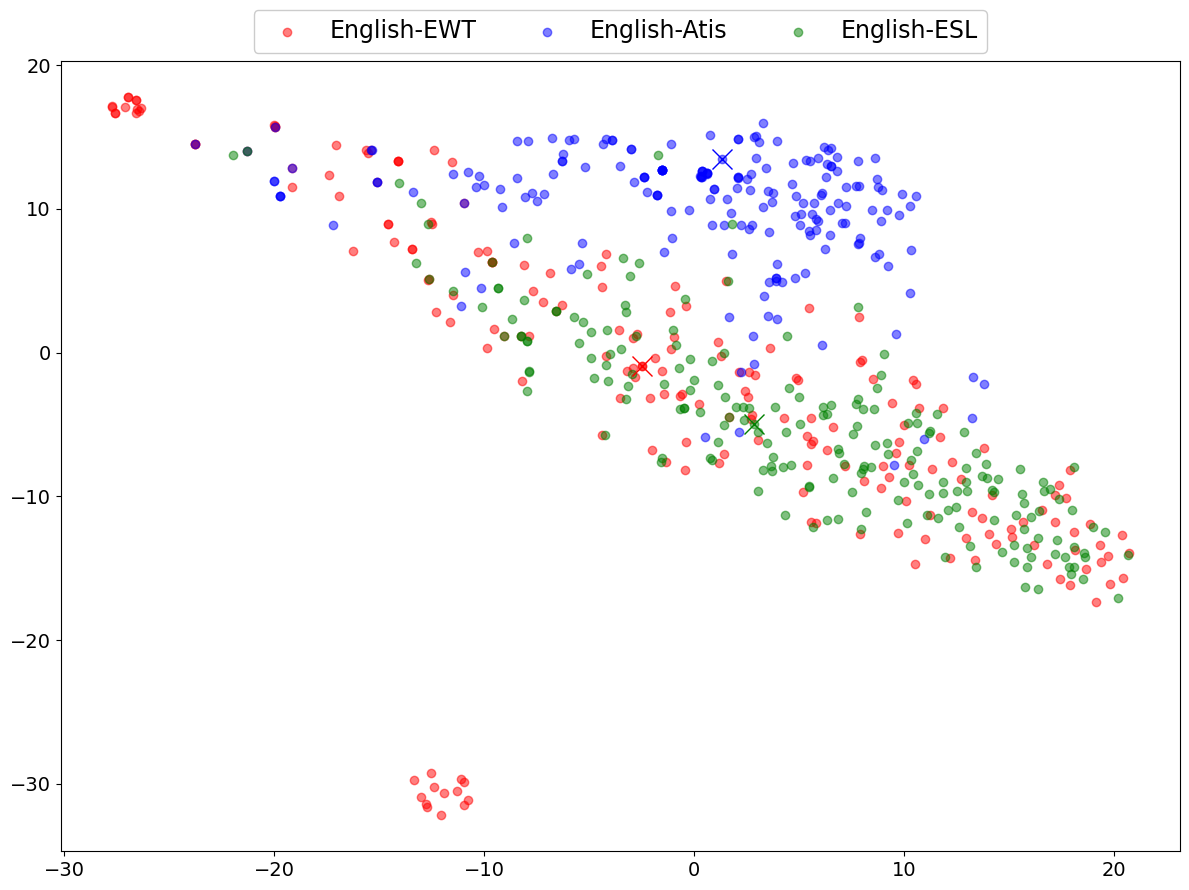

In [29]:
fig, ax = plt.subplots(tight_layout=True, figsize=(12,9))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='English-Atis', alpha=0.5, color='blue')
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='English-ESL', alpha=0.5, color='green')
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='green', markersize=15)

#ax.scatter(X_reduced[600:, 0], X_reduced[600:, 1], label='Rand-English-EWT-CF', alpha=0.8, color='orange')
#ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color='orange', markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4,  fontsize=17)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("english_nolimited_norand.png", bbox_inches='tight', dpi=300)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10'),
  Text(0, 12.0, '12'),
  Text(0, 14.0, '14')])

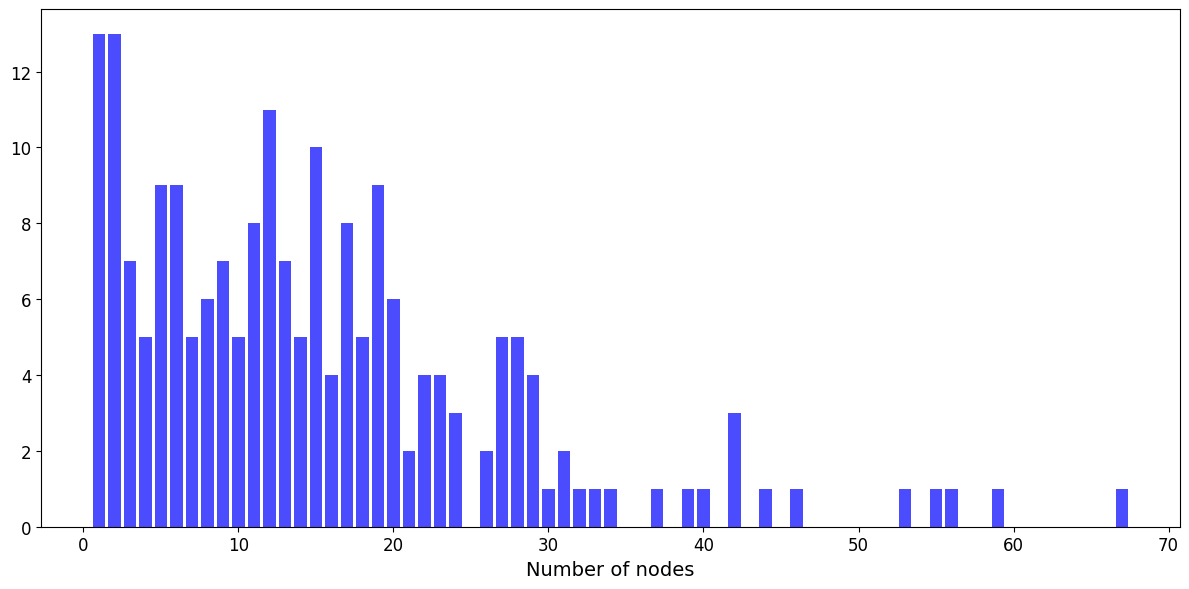

In [69]:
ewt_count = [13, 42, 7, 1, 20, 1, 8, 1, 20, 5, 9, 19, 17, 12, 27, 14, 3, 17, 15, 10, 5, 2, 30, 1, 12, 10, 7, 33, 6, 13, 27, 4, 8, 6, 12, 6, 1, 17, 13, 21, 27, 26, 21, 29, 23, 8, 5, 1, 26, 15, 13, 12, 6, 34, 9, 2, 1, 3, 7, 9, 59, 15, 20, 5, 9, 28, 20, 18, 2, 15, 19, 14, 28, 67, 12, 12, 17, 19, 3, 19, 31, 2, 24, 3, 15, 11, 18, 19, 29, 13, 31, 44, 6, 2, 24, 16, 23, 10, 15, 3, 18, 17, 15, 14, 12, 12, 22, 11, 2, 56, 2, 15, 1, 10, 16, 27, 1, 9, 12, 18, 37, 22, 40, 27, 8, 53, 13, 55, 18, 1, 32, 39, 28, 4, 2, 17, 20, 14, 7, 46, 4, 11, 1, 2, 5, 13, 8, 24, 22, 10, 11, 2, 11, 2, 4, 19, 12, 17, 29, 3, 4, 22, 20, 8, 6, 15, 9, 23, 17, 12, 15, 5, 5, 6, 3, 28, 23, 14, 6, 5, 19, 5, 19, 19, 16, 42, 16, 29, 2, 11, 9, 11, 28, 1, 42, 2, 7, 6, 1, 11]

ewt_count_list = Counter(ewt_count)

fig, ax = plt.subplots(tight_layout=True, figsize=(12,6))
ax.bar(ewt_count_list.keys(), ewt_count_list.values(), color='blue', alpha=0.7)
ax.set_xlabel("Number of nodes", fontsize=14)
#ax.set_ylabel("Number of nodes", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [32]:
ewt_count_list.keys()

dict_keys([13, 42, 7, 1, 20, 8, 5, 9, 19, 17, 12, 27, 14, 3, 15, 10, 2, 30, 33, 6, 4, 21, 26, 29, 23, 34, 59, 28, 18, 67, 31, 24, 11, 44, 16, 22, 56, 37, 40, 53, 55, 32, 39, 46])

In [37]:
ewt_count_list

Counter({1: 13,
         2: 13,
         12: 11,
         15: 10,
         5: 9,
         19: 9,
         6: 9,
         17: 8,
         11: 8,
         13: 7,
         9: 7,
         3: 7,
         20: 6,
         8: 6,
         7: 5,
         27: 5,
         14: 5,
         10: 5,
         4: 5,
         28: 5,
         18: 5,
         29: 4,
         23: 4,
         16: 4,
         22: 4,
         42: 3,
         24: 3,
         21: 2,
         26: 2,
         31: 2,
         30: 1,
         33: 1,
         34: 1,
         59: 1,
         67: 1,
         44: 1,
         56: 1,
         37: 1,
         40: 1,
         53: 1,
         55: 1,
         32: 1,
         39: 1,
         46: 1})

In [12]:
distArray = np.load(wasserTest_defs.DISTMX_DIR+"english_over5.npy")

In [19]:
X_reduced = TSNE(n_components=2, random_state=100, metric="precomputed", init="random").fit_transform(distArray)

In [20]:
ewt_array= distArray[:200,:200]
atis_array = distArray[200:400,200:400]
esl_array = distArray[400:600,400:600]
rand_array = distArray[600:,600:]

sums_ewt = [np.sum(ewt_array[i]) for i in range(200)]
sums_atis = [np.sum(atis_array[i]) for i in range(200)]
sums_esl = [np.sum(esl_array[i]) for i in range(200)]
sums_rand = [np.sum(rand_array[i]) for i in range(200)]

gmedians_id = [
    np.argmin(sums_ewt),
    np.argmin(sums_atis)+200,
    np.argmin(sums_esl)+400,
    np.argmin(sums_rand)+600
]


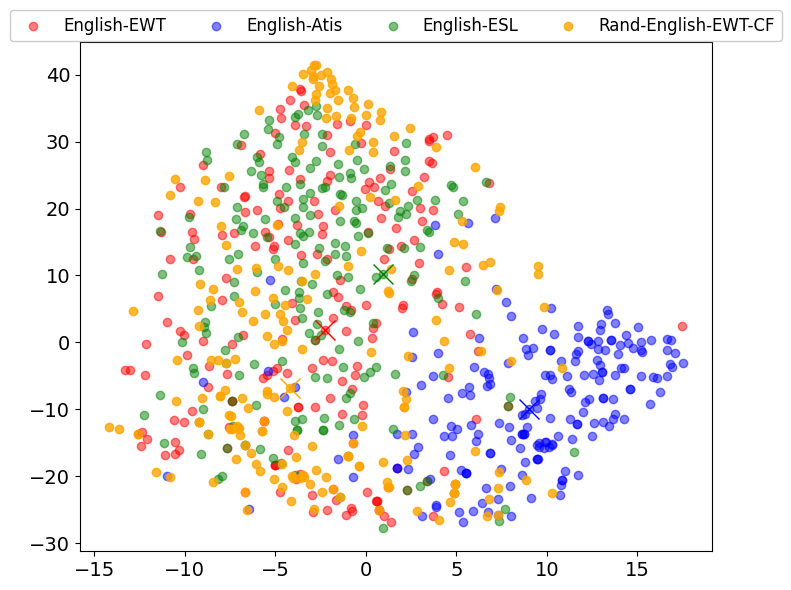

In [23]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='English-Atis', alpha=0.5, color='blue')
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='English-ESL', alpha=0.5, color='green')
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='green', markersize=15)

ax.scatter(X_reduced[600:, 0], X_reduced[600:, 1], label='Rand-English-EWT-CF', alpha=0.8, color='orange')
ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color='orange', markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4,  fontsize=12)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("english_over5.png", bbox_inches='tight', dpi=300)

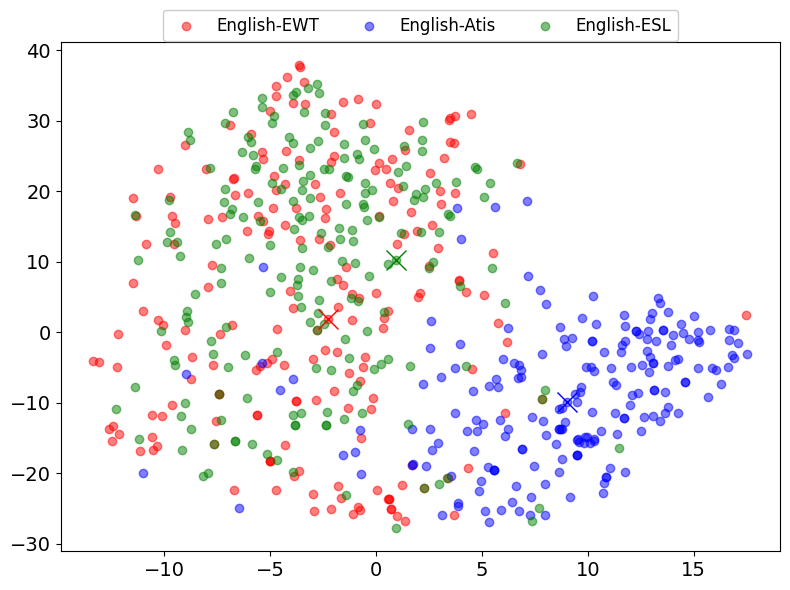

In [25]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color='red')
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color='red', markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='English-Atis', alpha=0.5, color='blue')
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color='blue', markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='English-ESL', alpha=0.5, color='green')
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color='green', markersize=15)

#ax.scatter(X_reduced[600:, 0], X_reduced[600:, 1], label='Rand-English-EWT-CF', alpha=0.8, color='orange')
#ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color='orange', markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=3,  fontsize=12)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("english_over5_norand.png", bbox_inches='tight', dpi=300)

In [14]:
!ls /home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/*_over5.npy

/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/english_over5.npy
/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/multiple_over5.npy
/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/parser_over5.npy
/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/randsAll_over5.npy
/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/rands_over5.npy


In [13]:
print(wasserTest_defs.DISTMX_DIR)

/home/yamazoe/zoe/data/numpy_data/distmx/ewt_other/


In [15]:
DistArray = np.load(wasserTest_defs.DISTMX_DIR+"multiple_over5.npy")

In [16]:
X_reduced = TSNE(n_components=2, 
                 random_state=100, 
                 metric="precomputed", 
                 init="random").fit_transform(DistArray)

In [18]:
en_array= DistArray[:200,:200]
fr_array = DistArray[200:400,200:400]
ja_array = DistArray[400:600,400:600]
ko_array = DistArray[600:,600:]

sums_en = [np.sum(en_array[i]) for i in range(200)]
sums_fr = [np.sum(fr_array[i]) for i in range(200)]
sums_ja = [np.sum(ja_array[i]) for i in range(200)]
sums_ko = [np.sum(ko_array[i]) for i in range(200)]

gmedians_id = [
    np.argmin(sums_en),
    np.argmin(sums_fr)+200,
    np.argmin(sums_ja)+400,
    np.argmin(sums_ko)+600
]


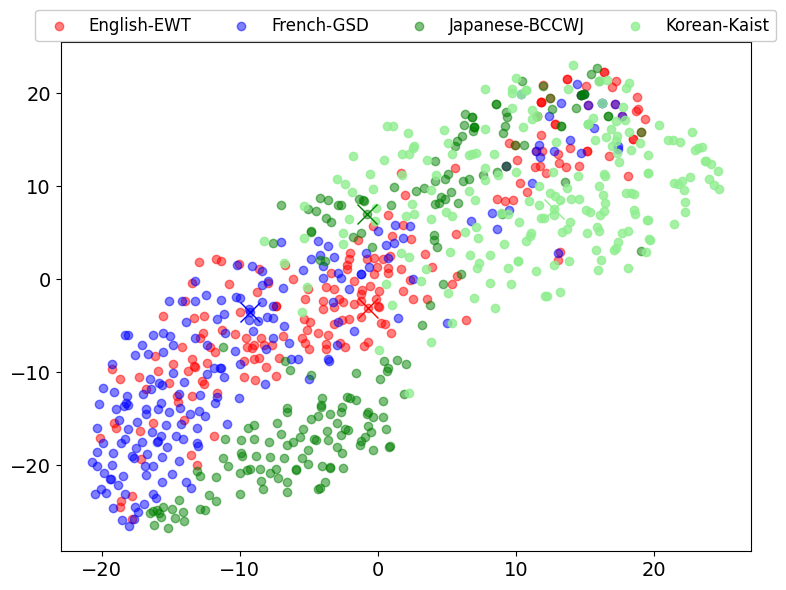

In [20]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[:200, 0], X_reduced[:200, 1], label='English-EWT', alpha=0.5, color=wasserTest_defs.PLOT_COLORS["English-EWT"])
ax.plot(X_reduced[gmedians_id[0], 0], X_reduced[gmedians_id[0], 1], 'x', color=wasserTest_defs.PLOT_COLORS["English-EWT"], markersize=15)

ax.scatter(X_reduced[200:400, 0], X_reduced[200:400, 1], label='French-GSD', alpha=0.5, color=wasserTest_defs.PLOT_COLORS["French-GSD"])
ax.plot(X_reduced[gmedians_id[1], 0], X_reduced[gmedians_id[1], 1], 'x', color=wasserTest_defs.PLOT_COLORS["French-GSD"], markersize=15)

ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='Japanese-BCCWJ', alpha=0.5, color=wasserTest_defs.PLOT_COLORS["Japanese-BCCWJ"])
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color=wasserTest_defs.PLOT_COLORS["Japanese-BCCWJ"], markersize=15)

ax.scatter(X_reduced[600:, 0], X_reduced[600:, 1], label='Korean-Kaist', alpha=0.8, color=wasserTest_defs.PLOT_COLORS["Korean-Kaist"])
ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color=wasserTest_defs.PLOT_COLORS["Korean-Kaist"], markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4,  fontsize=12)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("multiple_over5_norand.png", bbox_inches='tight', dpi=300)

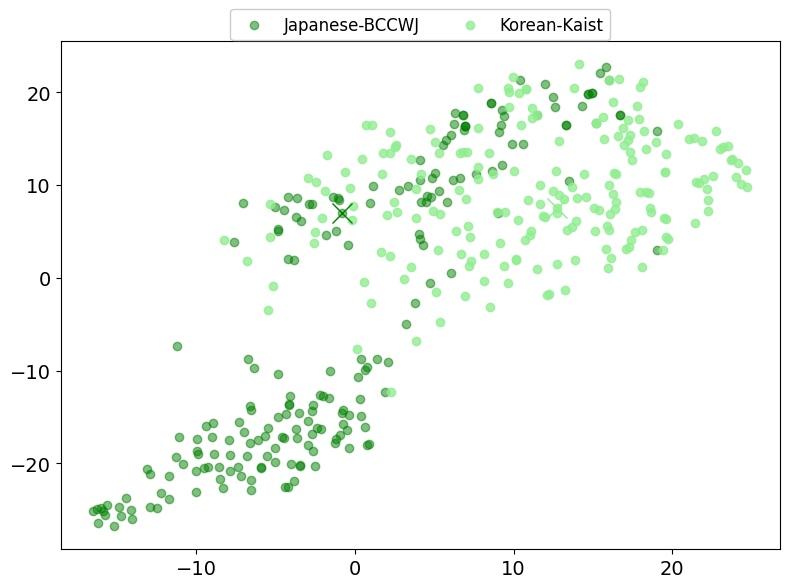

In [ ]:
# 日本語と韓国語のみを抜き出す

fig, ax = plt.subplots(tight_layout=True, figsize=(8,6))
ax.scatter(X_reduced[400:600, 0], X_reduced[400:600, 1], label='Japanese-BCCWJ', alpha=0.5, color=wasserTest_defs.PLOT_COLORS["Japanese-BCCWJ"])
ax.plot(X_reduced[gmedians_id[2], 0], X_reduced[gmedians_id[2], 1], 'x', color=wasserTest_defs.PLOT_COLORS["Japanese-BCCWJ"], markersize=15)

ax.scatter(X_reduced[600:, 0], X_reduced[600:, 1], label='Korean-Kaist', alpha=0.8, color=wasserTest_defs.PLOT_COLORS["Korean-Kaist"])
ax.plot(X_reduced[gmedians_id[3], 0], X_reduced[gmedians_id[3], 1], 'x', color=wasserTest_defs.PLOT_COLORS["Korean-Kaist"], markersize=15, alpha=1)

fig.subplots_adjust(left= 0.1,right= 0.9,top= 0.7,bottom = 0.1)
fp = FontProperties(fname="/home/yamazoe/zoe/fonts/unifont.ttf", size=24)

legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4,  fontsize=12)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0,0,0,0))

ax.tick_params(axis='both', which='major', labelsize=14)


In [ ]:
with open("/home/yamazoe/zoe/logs/geodesic/multiple_counts_over5.txt", "r") as f:
    lines = f.readlines()
    

['EWT: [8, 22, 24, 9, 7, 8, 14, 20, 21, 29, 15, 27, 25, 13, 14, 20, 44, 16, 27, 8, 6, 8, 7, 19, 31, 13, 20, 17, 32, 11, 9, 15, 12, 24, 9, 6, 6, 16, 13, 16, 20, 14, 15, 6, 19, 11, 9, 77, 17, 14, 22, 18, 23, 19, 33, 29, 65, 8, 13, 6, 6, 21, 22, 7, 23, 13, 30, 7, 17, 16, 16, 20, 19, 17, 20, 22, 24, 14, 18, 8, 40, 16, 9, 40, 72, 14, 21, 68, 13, 22, 6, 18, 20, 31, 9, 27, 29, 18, 22, 42, 9, 6, 22, 17, 30, 40, 30, 19, 27, 19, 14, 16, 32, 30, 8, 13, 15, 19, 15, 19, 17, 19, 29, 8, 10, 9, 11, 21, 6, 7, 8, 16, 22, 41, 14, 12, 19, 11, 23, 15, 7, 35, 8, 12, 27, 8, 13, 7, 44, 42, 14, 10, 12, 15, 11, 12, 10, 24, 22, 15, 23, 6, 12, 12, 41, 23, 16, 8, 30, 21, 19, 25, 34, 18, 32, 17, 12, 27, 11, 16, 17, 17, 22, 22, 13, 13, 16, 24, 7, 30, 17, 18, 15, 10, 19, 14, 7, 15, 18, 18]\n', 'French: [61, 19, 27, 21, 104, 80, 20, 6, 14, 7, 23, 22, 47, 31, 19, 17, 25, 38, 16, 20, 7, 42, 45, 11, 39, 29, 28, 33, 31, 60, 30, 33, 43, 27, 18, 27, 44, 9, 32, 16, 37, 46, 31, 26, 81, 25, 19, 37, 16, 29, 33, 27, 7, 38, 8, 45

In [ ]:
# 色分けを文の長さでやってみる


